In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [2]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        
        node_connection = np.empty_like(edge)
        self.node_adj = np.zeros((data.shape[0], data.shape[0]), dtype=np.bool)

        for i, (cited, citing) in enumerate(edge):
            node_connection[i] = (self.paper2node[cited], self.paper2node[citing])
            self.node_adj[node_connection[i][0]][node_connection[i][1]] = True
            self.node_adj[node_connection[i][1]][node_connection[i][0]] = True
            self.node_adj[node_connection[i][0]][node_connection[i][0]] = True
            self.node_adj[node_connection[i][1]][node_connection[i][1]] = True



    def get_dataset(self):

        node_x = np.array(self.node_feature, dtype=np.int32)
        node_y = np.array(self.node_label, dtype=np.int32)
        adjmat = np.array(self.node_adj, dtype=np.bool)
        return node_x, node_y, adjmat
        

cora = Cora(base_dir='/content/drive/My Drive')



node_x, node_y, adjmat = cora.get_dataset()


In [4]:
def xavier_weight(*size):
    return torch.nn.init.xavier_uniform_(torch.empty(*size))



class GraphAttentionLayer(nn.Module):
    def __init__(self, n_in, n_head, n_feature):
        super().__init__()

        self.n_head = n_head
        self.n_feature = n_feature

        self.weight = nn.Parameter(xavier_weight(n_in, n_head * n_feature))

        self.a_proj = nn.Parameter(xavier_weight(n_head, 2 * n_feature))

    def forward(self, x, mask):
        n_node = x.size(0)

        x = (x @ self.weight).view(n_node, self.n_head, self.n_feature)
        

        x_keys = x.unsqueeze(dim=0).expand(n_node, -1, -1, -1).view(n_node, n_node, self.n_head, self.n_feature)




        x = torch.cat([x.unsqueeze(dim=1).expand(-1, n_node, -1, -1).view(n_node, n_node, self.n_head, self.n_feature), 
                       x_keys], dim=3) * self.a_proj # [N, N, H, 2*F']
    
        x = x.sum(dim=3) # [N, N, H]


        x = F.leaky_relu(x, 0.2)

        x = x.masked_fill(mask, -np.inf)


        x = torch.softmax(x, dim=1).unsqueeze(dim=3) # [N, N, H, 1]
        
        x = x * x_keys # [N, N, H, F']

        x = x.sum(dim=1) # [N, H, F']

        x = x.flatten(1, 2)

        return x



class GATBlock(nn.Module):
    def __init__(self, n_in, n_head, n_feature, p):
        super().__init__()
        self.gat = GraphAttentionLayer(n_in, n_head, n_feature)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p) 
        
    def forward(self, x, mask):
        x = self.gat(x, mask)
        x = self.dropout(x)
        x = self.act(x)
        return x


class GAT(nn.Module):
    def __init__(self, n_in, n_head, n_feature, n_out):
        super().__init__()

        self.n_head = n_head
        n_hid = n_head * n_feature
        self.layer_in = nn.Sequential(nn.Linear(n_in, n_hid), nn.ELU(), nn.Dropout(0.6))
        self.layer = nn.ModuleList([
            GATBlock(n_hid, n_head, n_feature, 0.6),
            GATBlock(n_hid, n_head, n_feature, 0.6)
        ])        
        self.layer_out = nn.Linear(n_hid, n_out)

    
    def forward(self, x, mask):

        mask = mask.unsqueeze(2).expand(-1, -1, self.n_head)
        x = self.layer_in(x)
        for gat in self.layer:
            x = gat(x, mask)
        x = self.layer_out(x)
        return x



In [5]:
adj = torch.from_numpy(adjmat).bool()
X = torch.Tensor(node_x.astype(np.float))
X = X / X.sum(dim=1, keepdim=True)
target = torch.LongTensor(node_y)

In [7]:
idx_train = range(200)
idx_test = range(200, len(X))
idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)
mask = adj == False
model = GAT(n_in=len(node_x[0]), n_head=5, n_feature=8, n_out=7) # n_head > 5 exceeds my available RAM size (about 12GB)
solver = optim.Adam(model.parameters(),  lr=1e-2, weight_decay=1e-6)

In [8]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(100):
    solver.zero_grad()
    Y = model(X, mask)
    loss = F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean')
    loss.backward()
    solver.step()
    print(loss.item())
    with torch.no_grad():
        model.eval()
        Y = model(X, mask)
        train_loss.append(F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean').item())
        test_loss.append(F.cross_entropy(Y[idx_test], target[idx_test], reduction='mean').item())
        train_acc.append((Y[idx_train].argmax(dim=1) == target[idx_train]).sum().item() / len(idx_train))
        test_acc.append((Y[idx_test].argmax(dim=1) == target[idx_test]).sum().item() / len(idx_test))
        model.train()


1.9234570264816284
1.9038276672363281
1.890452265739441
1.8576158285140991
1.8286089897155762
1.8060928583145142
1.782339334487915
1.7804276943206787
1.7763632535934448
1.7107021808624268
1.6636043787002563
1.6095263957977295
1.5606110095977783
1.4912405014038086
1.4103056192398071
1.3255218267440796
1.2193539142608643
1.1291145086288452
1.053485631942749
1.019580364227295
0.9293005466461182
0.8792071342468262
0.8053147196769714
0.7733323574066162
0.6608118414878845
0.6192256808280945
0.651113748550415
0.5340316295623779
0.5295085310935974
0.5159075260162354
0.39954012632369995
0.4008359909057617
0.39324474334716797
0.3795172870159149
0.3830912411212921
0.302001029253006
0.24494893848896027
0.28336724638938904
0.2418772578239441
0.21270713210105896
0.22270384430885315
0.20055101811885834
0.1635507196187973
0.16730457544326782
0.18453535437583923
0.19255061447620392
0.1331862211227417
0.11976546049118042
0.13953574001789093
0.15311342477798462
0.14390897750854492
0.08643842488527298
0.1

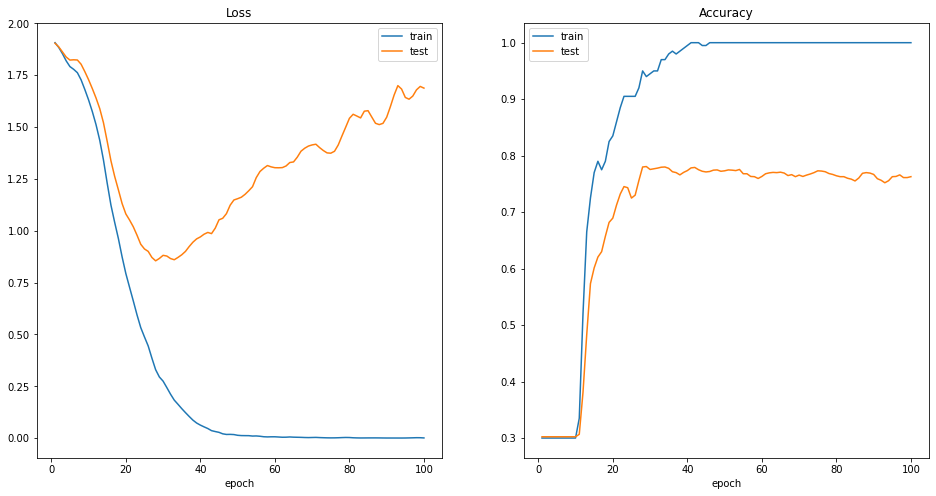

train loss :  0.0009334198548458517
test loss :  1.6873364448547363
train accuracy :  1.0
test accuracy :  0.7627591706539075


In [9]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(train_loss) + 1), train_loss, label='train')
ax.plot(range(1, len(test_acc) + 1), test_loss, label='test')

ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.legend()

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(train_acc) + 1), train_acc, label='train')
ax.plot(range(1, len(test_acc) + 1), test_acc, label='test')
ax.set_title('Accuracy')
ax.set_xlabel('epoch')

ax.legend()
plt.show()
print('train loss : ', train_loss[-1])
print('test loss : ', test_loss[-1])
print('train accuracy : ', train_acc[-1])
print('test accuracy : ', test_acc[-1])